In [1]:
import glob
import numpy as np
import os
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import cv2
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch_directml
import matplotlib.image as imgs
import matplotlib.pyplot as plt
from transformers import BeitImageProcessor, BeitForImageClassification
import random

In [2]:
dml = torch_directml.device()

In [3]:
base_model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")
base_model.classifier = nn.Sequential(nn.Linear(in_features=768, out_features=256, bias=True),
                                      nn.Linear(in_features=256, out_features=2, bias=True))
base_model = base_model.to(dml)

In [4]:
model_path = "../trained-models/beit_custom.pt"
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['beit.encoder.layer.0.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.1.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.2.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.3.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.4.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.5.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.6.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.7.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.8.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.9.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.10.attention.atten

In [5]:
image_processor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224") 

def my_transform(image):
    pil_image = Image.fromarray(image)
    pixel_values = image_processor(pil_image, return_tensors="pt").pixel_values
    return pixel_values.squeeze()

In [6]:
def batch_predict(images):
    base_model.eval()
    batch = torch.stack(tuple(my_transform(i) for i in images), dim=0)
    batch = batch.to(dml)
    
    logits = base_model(batch).logits
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [7]:
def explain_image(image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(image), 
                                            batch_predict, # classification function
                                            hide_color=0, 
                                            batch_size=20,
                                            random_seed=240,
                                            num_samples=1000)
  
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
  
    return img_boundry2

In [8]:
misclassified = [x.split("\\")[-1].split("_")[0] + '_' + x.split("\\")[-1].split("_")[1] for x in glob.glob("../images/misclassified-new/beit-custom/*")]
# all_images = glob.glob("../splitted/test/0/*")
all_images = glob.glob("../splitted/test/1/*")

In [9]:
correctly_classified = []
for img_path in all_images:
    img_no = img_path.split("\\")[-1].split(".")[0]
    if img_no not in misclassified:
        correctly_classified.append(img_path)

sampled_images = random.sample(correctly_classified, 10)

In [11]:
images = []
for path in sampled_images:
    mask_no = path.split("\\")[-1].split("_")[0]
    folder_no = path.split("/")[-1].split("\\")[0]
    mask_path = f"../images/mask/{folder_no}/{mask_no}.png"

    img = cv2.imread(path)
    masked_image = explain_image(img)
    
    images.append((img, masked_image, cv2.imread(mask_path)))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

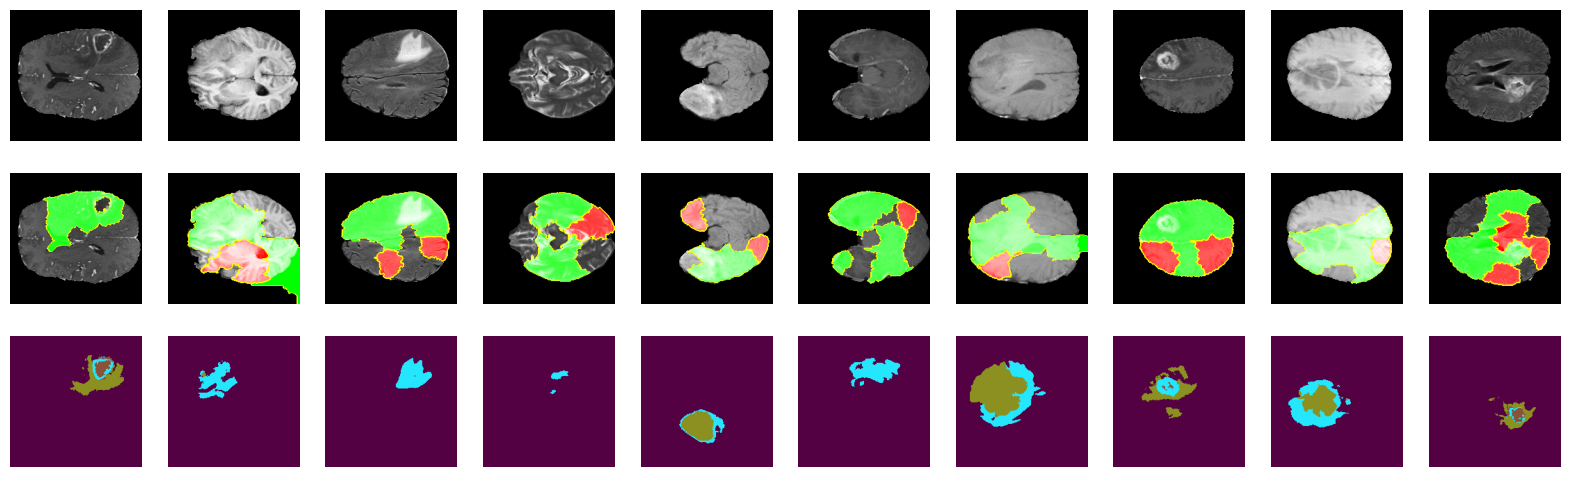

In [12]:
fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i in range(len(sampled_images)):
    axes[0, i].axis("off")
    axes[0, i].imshow(images[i][0])
    
    axes[1, i].axis("off")
    axes[1, i].imshow(images[i][1])
    
    axes[2, i].axis("off")
    axes[2, i].imshow(images[i][2])
    
plt.show()